# Homework 4
## Classification with Python

This homework is a test of my classification abilities. I will be working through the Kaggle competition "[Costa Rican Household Poverty Level Prediction](https://www.kaggle.com/c/costa-rican-household-poverty-prediction)". Accuracy is the evaluation metric for the Kaggle competition, but I will also be exploring how well my model does on multiple metrics like F1, precision, recall, and area under the ROC curve. 

## Problem
The problem that this Kaggle competition is addressing has to do with how Latin American governments measure a family's need for financial aid. Most of the world's poorest do not have sufficient income and expense records to be able to qualify for such programs, so Latin America has implement programs that look at other living aspects like the quality of the home and the assets they possess. 

## Goal
The goal for this project will be to develop a model that can accurately classify the social needs of a family based off of the different data collected for a Proxy Means Test that looks at living aspects like the ones mentioned above. 

## Table of Contents
- Import the Data
- Data Cleaning and Imputation
- Feature Engineering
    - Household Variables
    - Individual Variables
- Exploring The New DataFrame
    - Target Variable
    - Education Variables
    - House Quality Variables
    - Penalty
- Modeling
- Exploring the Model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import norm, skew 
from scipy.stats import uniform as sp_rand
import time

#Silencing deprication warnings
import warnings
warnings.filterwarnings("ignore")

#Import libraries for modeling and validation
from sklearn.ensemble import RandomForestClassifier
from lightgbm import LGBMClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score, train_test_split, RandomizedSearchCV
from sklearn.metrics import f1_score, roc_curve, auc, classification_report

# Import the Data

There are two sets of data that I will use for this project: a test set and a train set. The train set contains a target column whereas the test does not. I will use the train data to train my model that I will then use on the test data for the Kaggle submission (although, this project does not require a Kaggle submission). The data can be found [here](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data).

In [2]:
#I am importing the train and test data files that I downloaded from Kaggle
train = pd.read_csv("file:///Users/Codis_Joben/Documents/Pythondocs/CostaRicanHouseholdPoverty/train.csv")
test = pd.read_csv("file:///Users/Codis_Joben/Documents/Pythondocs/CostaRicanHouseholdPoverty/test.csv")

#Setting the target variable, parentesco1 indicates the head of household 
y = train.loc[(train['parentesco1']==1), 'Target']

#Set Id variable
Id = test.Id

In [3]:
pd.options.display.max_columns = 150
train.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,r4h3,r4m1,r4m2,r4m3,r4t1,r4t2,r4t3,tamhog,tamviv,escolari,rez_esc,hhsize,paredblolad,paredzocalo,paredpreb,pareddes,paredmad,paredzinc,paredfibras,paredother,pisomoscer,pisocemento,pisoother,pisonatur,pisonotiene,pisomadera,techozinc,techoentrepiso,techocane,techootro,cielorazo,abastaguadentro,abastaguafuera,abastaguano,public,planpri,noelec,coopele,sanitario1,sanitario2,sanitario3,sanitario5,sanitario6,energcocinar1,energcocinar2,energcocinar3,energcocinar4,elimbasu1,elimbasu2,elimbasu3,elimbasu4,elimbasu5,elimbasu6,epared1,epared2,epared3,etecho1,etecho2,etecho3,eviv1,eviv2,eviv3,dis,male,female,estadocivil1,estadocivil2,estadocivil3,estadocivil4,estadocivil5,estadocivil6,estadocivil7,parentesco1,parentesco2,parentesco3,parentesco4,parentesco5,parentesco6,parentesco7,parentesco8,parentesco9,parentesco10,parentesco11,parentesco12,idhogar,hogar_nin,hogar_adul,hogar_mayor,hogar_total,dependency,edjefe,edjefa,meaneduc,instlevel1,instlevel2,instlevel3,instlevel4,instlevel5,instlevel6,instlevel7,instlevel8,instlevel9,bedrooms,overcrowding,tipovivi1,tipovivi2,tipovivi3,tipovivi4,tipovivi5,computer,television,mobilephone,qmobilephone,lugar1,lugar2,lugar3,lugar4,lugar5,lugar6,area1,area2,age,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,1,1,0,0,0,0,1,1,1,1,10,NaN,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,21eb7fcc1,0,1,0,1,no,10,no,10.0,0,0,0,1,0,0,0,0,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,43,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,1,1,0,0,0,0,1,1,1,1,12,NaN,1,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0e5d7a658,0,1,1,1,8,12,no,12.0,0,0,0,0,0,0,0,1,0,1,1.000000,0,0,1,0,0,0,0,1,1,1,0,0,0,0,0,1,0,67,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,0,0,0,1,1,0,1,1,1,1,11,NaN,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,1,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,2c7317ea8,0,1,1,1,8,no,11,11.0,0,0,0,0,1,0,0,0,0,2,0.500000,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,92,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,9,1.0,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,1,0,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,17,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,2,2,1,1,2,1,3,4,4,4,11,NaN,4,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,2b58d945f,2,2,0,4,yes,11,no,11.0,0,0,0,0,1,0,0,0,0,3,1.333333,0,0,1,0,0,0,0,1,3,1,0,0,0,0,0,1,0,37,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9557 entries, 0 to 9556
Columns: 143 entries, Id to Target
dtypes: float64(8), int64(130), object(5)
memory usage: 10.4+ MB


The data set has 143 columns. 130 are integers and most likely represent boolean values. 8 are float and 5 are objects. I will need to take a look at the object variables and create dummy variables for them before I can use the data for modeling. 

# Data Cleaning and Imputation

I will now go through the data and fix any missing values as well as take care of those categorical variables. This process will also help me see any other needs for imputing the data and will help with any feature engineering that is necessary. 

In [5]:
#I will combine my data sets to clean them both at the same time
ntrain = train.shape[0]
data = pd.concat((train.drop('Target', axis = 1), test)).reset_index(drop = True)
data = data.drop('Id', axis = 1)
ntrain

9557

In [6]:
#Checking shape to make sure I dropped the ID and Target columns
data.shape

(33413, 141)

In [7]:
#Checking for missing data
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(6)

,Total,Percent
rez_esc,27581,0.825457
v18q1,25468,0.762218
v2a1,24263,0.726154
meaneduc,36,0.001077
SQBmeaned,36,0.001077
v14a,0,0.000000


The data is looking pretty good, only 5 of my columns contain missing values. 3 of those columns are missing the majority, so I will now take a closer look and see what is really going on there. First, I will take a look at the [data description](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/data) and figure out what these variables are supposed to be showing. 

- **rez_esc**, Years behind in school. This probably only applies to individuals younger than 18.<br><br>
- **v18q1**, number of tablets household owns. Missing data probably indicates that there are no tablets.<br><br>
- **v2a1**, Monthly rent payment. I'll need to take a closer look to understand what is going on here.<br><br>
- **meaneduc**,average years of education for adults (18+). This could mean there is no education, but I will need to check that.<br><br>
- **SQBmeaned**, square of the mean years of education of adults (>=18) in the household. This data is just missing from the meaneduc data.



In [8]:
#Comparing v18q to v18q1 to see if the missing data really means there are no tablets in the home
data.groupby('v18q')['v18q1'].apply(lambda x: x.isnull().sum())

v18q
0    25468
1        0
Name: v18q1, dtype: int64

In [9]:
#Just as I thought, the missing data is due to the household not having tablets as marked in v18q
#Setting missing values to 0
data.v18q1 = data.v18q1.fillna(0)

To really understand what is going on with the data in v2a1, it will be important to look at the ownership/renting status of the home. To do this, I will plot the missing values in v2a1 by their different ownership/renting classifiers. The following code was adapted from [Will Koehrsen](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough).

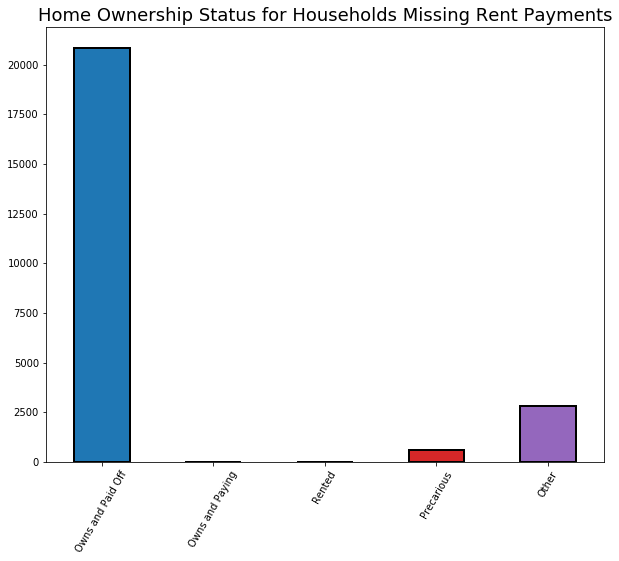

In [10]:
#Variables indicating home ownership
own_variables = [x for x in data if x.startswith('tipo')]

#Plot of the home ownership variables for home missing rent payments
data.loc[data['v2a1'].isnull(), own_variables].sum().plot.bar(figsize = (10, 8),
                                                              edgecolor = 'k', linewidth = 2);
plt.xticks([0, 1, 2, 3, 4],
           ['Owns and Paid Off', 'Owns and Paying', 'Rented', 'Precarious', 'Other'],
          rotation = 60)
plt.title('Home Ownership Status for Households Missing Rent Payments', size = 18);

The vast majority of missing v2a1 (Monthly Rent Payment) values come from households that own and have paid off their home. That means their rent is essentially 0. 

In [11]:
#Setting the rent of households that own the home to 0
data.loc[(data['tipovivi1'] == 1), 'v2a1'] = 0

In [12]:
#I am going to create a couple of columns that will indicate a missing value in the rent data.
#Create missing rent payment column
data['v2a1-missing'] = data['v2a1'].isnull()
data['v2a1-missing'].value_counts()

False    29994
True      3419
Name: v2a1-missing, dtype: int64

In [13]:
#Now I am filling in the remaining missing data with the median values found only from the heads of households
data['v2a1'] = data.groupby('parentesco1')['v2a1'].transform(lambda x: x.fillna(x.median()))

Now I am going to take a look at the rez_esc missing data. According to the [discussion](https://www.kaggle.com/c/costa-rican-household-poverty-prediction/discussion/61403) for this competition, rez_esc only applies to individuals between 7 and 19, so any person out of that range I will set their rez_esc to zero. The rest of the data I will create columns that indicate missing data and then impute the missing data.

In [14]:
#Setting value to 0 if person is younger than 7 or older than 19.
data.loc[((data['age'] > 19) | (data['age'] < 7)) & (data['rez_esc'].isnull()), 'rez_esc'] = 0

#Creating missing years behind in school column
data['rez_esc-missing'] = data['rez_esc'].isnull()

#Filling in the data by grouping years behind in school with the age and using the median value
#This will handle most, but not all the null values
data['rez_esc'] = data.groupby('age')['rez_esc'].transform(lambda x: x.fillna(x.median()))
#Filling in the remaining rez_esc null values with median value of that column
data['rez_esc'] = data['rez_esc'].transform(lambda x: x.fillna(x.median()))

All that is left is to impute the meaneduc and SQBmeaned. I couldn't find much information on why this data is missing, so imputing them should fix the problem. Only 36 rows had missing data in these fields so it shouldn't be a big deal. 

In [15]:
#Filling meaneduc through groupby years of schooling median values. 
#Since these variables are related, it should provide the best data.
#For SQBmeaned, I will just square the new meaneduc data.
data['meaneduc'] = data.groupby('escolari')['meaneduc'].transform(lambda x: x.fillna(x.median()))
data['SQBmeaned'] = (data.meaneduc)**2

In [16]:
#Checking to make sure all null values were filled
data.isnull().any().sum()

0

Now it is time to fix the categorical variables. Before getting started, I will take a look at which variables are categorical and then refer to the competition documentation on what the different values mean.

In [17]:
data.select_dtypes(include = 'object').head()

,idhogar,dependency,edjefe,edjefa
0,21eb7fcc1,no,10,no
1,0e5d7a658,8,12,no
2,2c7317ea8,8,no,11
3,2b58d945f,yes,11,no
4,2b58d945f,yes,11,no


These are the four categorical variables that I will need to fix before modeling. The 'idhogar' is just an identification number, so I will be dropping it before running my models. The other three variables contain yes, no, and integer values. According to the data description, yes means 1 and no means 0, so the following code will set those values accordingly and then change the columns to be integer variables instead of categorical variables. 

In [18]:
categorical = ['dependency', 'edjefe', 'edjefa']
for col in categorical:
    data.loc[(data[col] == 'yes'), col]=1
    data.loc[(data[col] == 'no'), col]=0
data[categorical] = data[categorical].apply(pd.to_numeric)

# Feature Engineering

Feature Engineering will help my models to perform much more effectively for my analysis. A large portion of this section will be using code and insights from [Will Koehrsen](https://www.kaggle.com/willkoehrsen/a-complete-introduction-and-walkthrough), who has provided good information on the importance of looking at the data both on an individual level and a household level. I will also be referring to some of the feature engineering done by [ngriffiths13](https://github.com/codyp35/Applied_Machine_Learning_Classwork/blob/master/Homeworks/HW4/Homework%204%20-%20Costa%20Rica%20Poverty%20Classification.ipynb), who did this project in the past.

It has been helpful for me during this project to refer to the kaggle discussions, kernels, and past work done by others who have participated in this competition. While I have learned a lot from others and have borrowed some code, I have added my own personal touch to every aspect of this project to tailor it to my own preferences and ideas. I've also put forth effort to improve on any of the information and code borrowed from others. 

In [19]:
#Squared Variables, these will be removed 
sqr_ = ['SQBescolari', 'SQBage', 'SQBhogar_total', 'SQBedjefe', 
        'SQBhogar_nin', 'SQBovercrowding', 'SQBdependency', 'SQBmeaned', 'agesq']

I will now be removing all of the squared variables from the data. For the sophisticated models I will be using for this analysis, including the squared variables may actually end up hurting the model. These variables are highly correlated with their non-squared counterparts and will not provide additional insight for the analysis. 

In [20]:
#Removing all of the squared variables
data = data.drop(columns = sqr_)

## Household Variables

Now I am going to do some feature engineering on the household variables.

In some cases, there are more people living in a household (tamviv) then belong to the family of the household (hhsize). I think this would be an important indicator for the need of aid, so I will create a new variable indicating the households that fall in this category.

In [21]:
data['hhsize-diff'] = data['tamviv'] - data['hhsize']

In [22]:
#Combining features of the walls, roof, and floor into ordinal features
data['walls'] = np.argmax(np.array(data[['epared1', 'epared2', 'epared3']]),
                           axis = 1)
data = data.drop(columns = ['epared1', 'epared2', 'epared3'])

data['roof'] = np.argmax(np.array(data[['etecho1', 'etecho2', 'etecho3']]),
                           axis = 1)
data = data.drop(columns = ['etecho1', 'etecho2', 'etecho3'])

data['floor'] = np.argmax(np.array(data[['eviv1', 'eviv2', 'eviv3']]),
                           axis = 1)
data = data.drop(columns = ['eviv1', 'eviv2', 'eviv3'])

#Adding a feature that captures the overall quality of a home based on the walls, roof, and floor
data['OverallQual_wrf'] = data['walls'] + data['roof'] + data['floor']

In [23]:
#Fixing electricity markers to be ordinal and then creating a variable that indicates electricity or not
elec = []

for i, row in data.iterrows():
    if row['noelec'] == 1:
        elec.append(0)
    elif row['coopele'] == 1:
        elec.append(1)
    elif row['public'] == 1:
        elec.append(2)
    elif row['planpri'] == 1:
        elec.append(3)
    else:
        elec.append(np.nan)
        
#Creating a variable that flags missing data
data['elec'] = elec
data['elec-missing'] = data['elec'].isnull()

#Remove the other electricity columns
data = data.drop(columns = ['noelec', 'coopele', 'public', 'planpri'])

#Impute missing elec data
data.elec = data.elec.fillna(0)

In [24]:
#Adding a feature that penalizes a house -1 for not having a toilet, electricity, floor, water service, and/or ceiling
data['penalty'] = 1 * (data['sanitario1'] + 
                         (data['elec'] == 0) + 
                         data['pisonotiene'] + 
                         data['abastaguano'] + 
                         (data['cielorazo'] == 0))

In [25]:
#Adding a feature that gives bonus points to homes with a refigerator, computer, tablet, and/or television
data['asset_bonus'] = 1 * (data['refrig'] + 
                      data['computer'] + 
                      (data['v18q1'] > 0) + 
                      data['television'])

#Adding features that measure the number of important assets per person in the household
data['phones-per-person'] = data['qmobilephone'] / data['tamviv']
data['tablets-per-person'] = data['v18q1'] / data['tamviv']
data['rooms-per-person'] = data['rooms'] / data['tamviv']
data['rent-per-person'] = data['v2a1'] / data['tamviv']

The following two features come from ngriffiths13 work on this project. After reading the details on why he created these variables, I decided to also include them in my analysis.

In [26]:
#Adding a feature that measures the proportion of children in the home
data['child_ratio'] = data['hogar_nin'] / data['hogar_total']
#Adding a feature that measures the proportion of elderly individuals in the home
data['old_ratio'] = data['hogar_mayor'] / data['hogar_total']

## Individual Variables

Now I am going to do feature engineering on the individual variables.

There are several different education level columns. I will create one ordinal variable to capture this information since level 1 is no education and level 9 is postgraduate education, so the higher the number the better the education.

In [27]:
#Changing the individual education level to an ordinal variable 
data['EduLevel'] = np.argmax(np.array(data[[c for c in data if c.startswith('instl')]]), axis = 1)

#Dropping the other education columns
data = data.drop(columns = [c for c in data if c.startswith('instlevel')])

In [28]:
#Creating a feature that indicates the level of personal technology assets of an individual
data['ind_tech'] = data['v18q'] + data['mobilephone']

In [29]:
data.shape

(33413, 125)

In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33413 entries, 0 to 33412
Columns: 125 entries, v2a1 to ind_tech
dtypes: bool(3), float64(9), int64(112), object(1)
memory usage: 31.2+ MB


In [31]:
data.isnull().any().sum()

0

# Exploring The New DataFrame

I will now go through the cleaned up dataframe with the added features and the target variable to understand it better. I will be doing different visualizations to prepare myself for the modeling phase of this project.

In [32]:
train = data[:ntrain]
x = train.loc[train['parentesco1']==1].drop('idhogar', axis = 1)
train = pd.concat([x, y], axis = 1)
test = data[ntrain:].drop('idhogar', axis = 1)
train.shape

(2973, 125)

In [33]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2973 entries, 0 to 9552
Columns: 125 entries, v2a1 to Target
dtypes: bool(3), float64(9), int64(113)
memory usage: 2.8 MB


In [34]:
train.isnull().any().sum()

0

## Target Variable

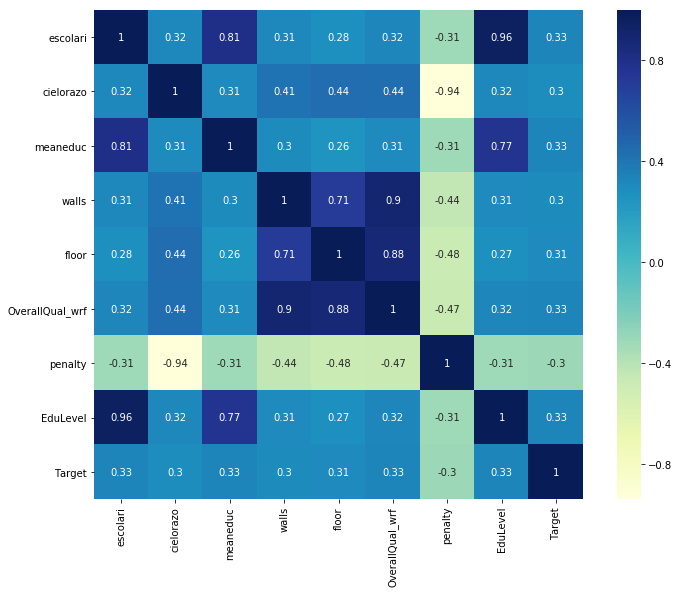

In [35]:
#Looking at the variables that are most correlated with Poverty Level (Target)
corr_train = train.corr()
highest_corr = corr_train.index[abs(corr_train["Target"])>0.29]
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(train[highest_corr].corr(), square = True, annot = True, cmap="YlGnBu")

The strongest correlation between the variables and the Target is a .33. The most strongly correlated variables are education level; the overall house quality according to the walls, roof, and floor; meaneduc; and escolari. 

([<matplotlib.axis.XTick at 0x1a23f09b38>,
 <a list of 4 Text xticklabel objects>)

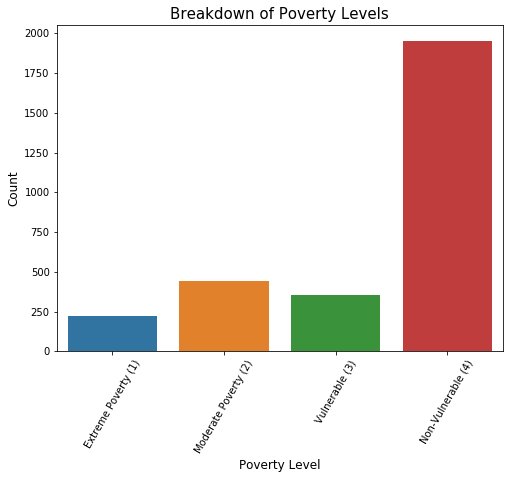

In [36]:
#Looking at the breakdown of the different poverty levels in my data
f, ax = plt.subplots(figsize=(8, 6))
sns.countplot(train.Target)
plt.title('Breakdown of Poverty Levels', fontsize=15)
plt.xlabel('Poverty Level', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks([0, 1, 2, 3],
           ['Extreme Poverty (1)', 'Moderate Poverty (2)', 'Vulnerable (3)', 'Non-Vulnerable (4)'],
          rotation = 60)

This poses a problem for my model. The model will do a good job learning from the 'non-vulnerable' households, but it will have a more difficult time learning how to identify the other levels of poverty because of the relatively small amount of data available. It is great to see that the majority of people in Costa Rica are not in serious poverty, but that doesn't help my model much. I will have to do something about the unbalanced data later on. 

Now I will be exploring the variables with the highest correlation to the Target. Looking closer at these variables should help me understand better how they relate to poverty levels. The following is a function taken from Will Koehrsen. It gives a great visualization of how the different independent variables relate to the target variable. I will be using this function to visualize some of the variables.

In [37]:
def plot_categoricals(x, y, data, annotate = True):
    """Plot counts of two categoricals.
    Size is raw count for each grouping.
    Percentages are for a given value of y."""
    
    # Raw counts 
    raw_counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = False))
    raw_counts = raw_counts.rename(columns = {x: 'raw_count'})
    
    # Calculate counts for each group of x and y
    counts = pd.DataFrame(data.groupby(y)[x].value_counts(normalize = True))
    
    # Rename the column and reset the index
    counts = counts.rename(columns = {x: 'normalized_count'}).reset_index()
    counts['percent'] = 100 * counts['normalized_count']
    
    # Add the raw count
    counts['raw_count'] = list(raw_counts['raw_count'])
    
    plt.figure(figsize = (14, 10))
    # Scatter plot sized by percent
    plt.scatter(counts[x], counts[y], edgecolor = 'k', color = 'lightgreen',
                s = 100 * np.sqrt(counts['raw_count']), marker = 'o',
                alpha = 0.6, linewidth = 1.5)
    
    if annotate:
        # Annotate the plot with text
        for i, row in counts.iterrows():
            # Put text with appropriate offsets
            plt.annotate(xy = (row[x] - (1 / counts[x].nunique()), 
                               row[y] - (0.15 / counts[y].nunique())),
                         color = 'navy',
                         s = f"{round(row['percent'], 1)}%")
        
    # Set tick marks
    plt.yticks(counts[y].unique())
    plt.xticks(counts[x].unique())
    
    # Transform min and max to evenly space in square root domain
    sqr_min = int(np.sqrt(raw_counts['raw_count'].min()))
    sqr_max = int(np.sqrt(raw_counts['raw_count'].max()))
    
    # 5 sizes for legend
    msizes = list(range(sqr_min, sqr_max,
                        int(( sqr_max - sqr_min) / 5)))
    markers = []
    
    # Markers for legend
    for size in msizes:
        markers.append(plt.scatter([], [], s = 100 * size, 
                                   label = f'{int(round(np.square(size) / 100) * 100)}', 
                                   color = 'lightgreen',
                                   alpha = 0.6, edgecolor = 'k', linewidth = 1.5))
        
    # Legend and formatting
    plt.legend(handles = markers, title = 'Counts',
               labelspacing = 3, handletextpad = 2,
               fontsize = 16,
               loc = (1.10, 0.19))
    
    plt.annotate(f'* Size represents raw count while % is for a given y value.',
                 xy = (0, 1), xycoords = 'figure points', size = 10)
    
    # Adjust axes limits
    plt.xlim((counts[x].min() - (6 / counts[x].nunique()), 
              counts[x].max() + (6 / counts[x].nunique())))
    plt.ylim((counts[y].min() - (4 / counts[y].nunique()), 
              counts[y].max() + (4 / counts[y].nunique())))
    plt.grid(None)
    plt.xlabel(f"{x}"); plt.ylabel(f"{y}"); plt.title(f"{y} vs {x}");

## Education Variables

EduLevel and MeanEduc are strongly correlated, so perhaps EduLevel was not the best additional feature, but I am going to go ahead and visualize it here. 

Text(0, 0.5, 'Average Poverty Level')

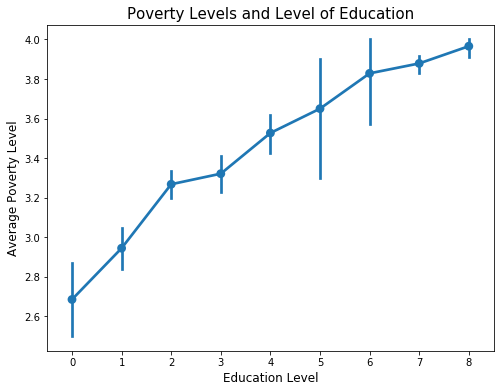

In [38]:
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['EduLevel'], y = train.Target)
plt.title('Poverty Levels and Level of Education', fontsize=15)
plt.xlabel('Education Level', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

Text(0, 0.5, 'Average Poverty Level')

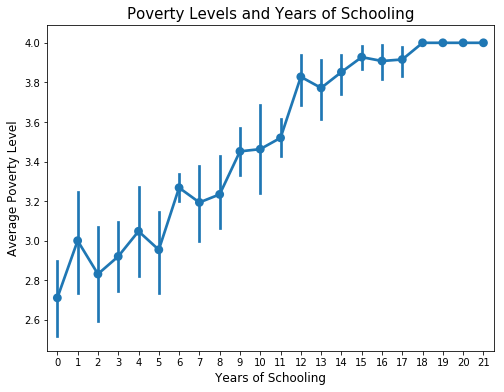

In [39]:
f, ax = plt.subplots(figsize=(8, 6))
sns.pointplot(x = train['escolari'], y = train.Target)
plt.title('Poverty Levels and Years of Schooling', fontsize=15)
plt.xlabel('Years of Schooling', fontsize=12)
plt.ylabel('Average Poverty Level', fontsize=12)

The graphs both tell us the same thing: More education leads to less poverty. This is exactly what you would expect. 

## House Quality Variables

The house quality variables are also all closely related, as to be expected, but I'm going to visualize each one to see how they vary. 

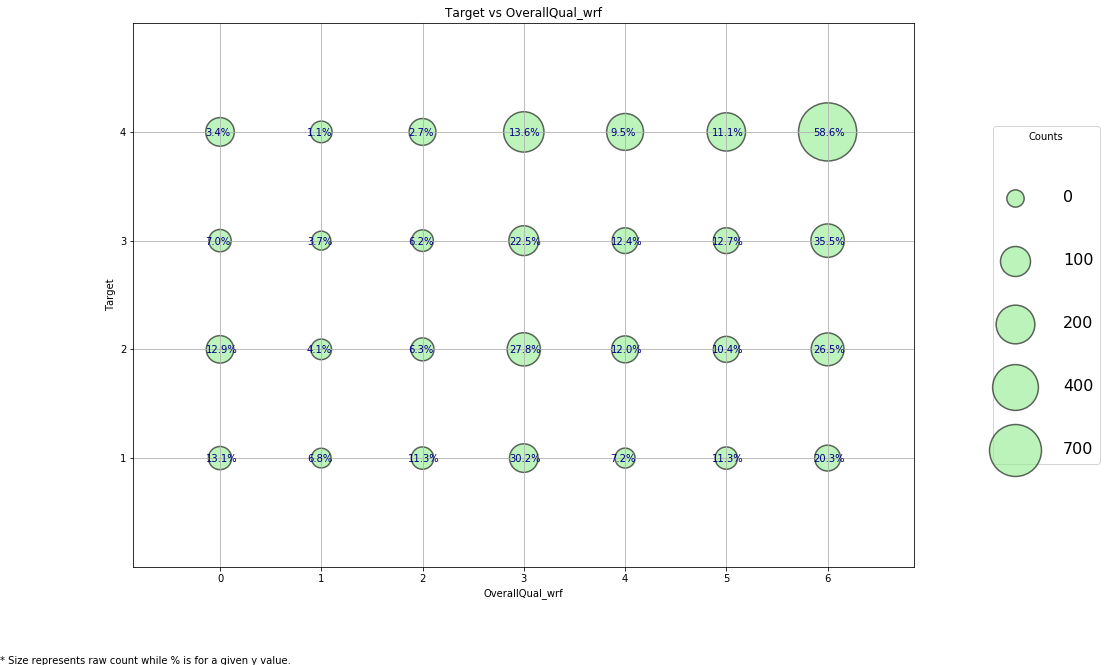

In [40]:
plot_categoricals('OverallQual_wrf', 'Target', train);

As shown in this chart, those who are not in poverty tend to have a higher quality of house whereas those who are in poverty have a lower quality of house. 

## Penalty

The penalty variable I created had a strong negative correlation. This is something that I have not seen during my machine learning experience so far. I'd like to take a closer look to see what is happening. I am pretty sure this is the kind of relation I wanted to create with the penalty, but it is good to be sure. 

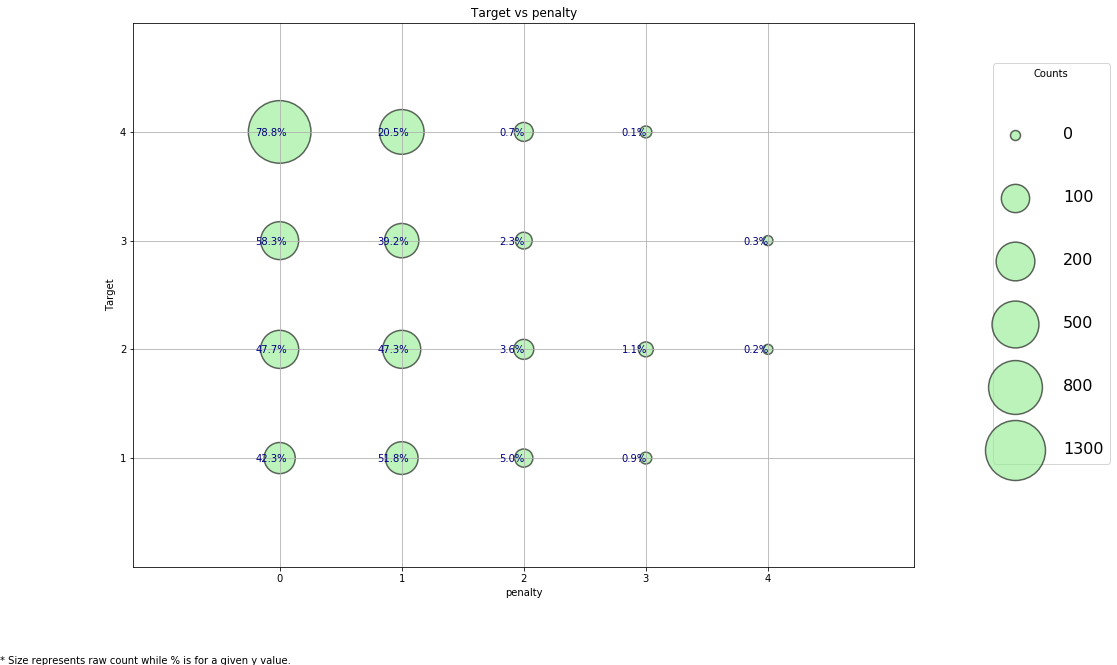

In [41]:
plot_categoricals('penalty', 'Target', train);

So the more penalty you have (like missing a toilet or not having electricity) the more poverty you appear to be in. This is exactly what I expected to see in the variable. The majority of those not living in poverty had no penalties, which makes sense since the items incorporated in the variable are very important. 

# Modeling

Now it's time to get to some modeling. I will try and test a few different models, using the macro-F1 score as a quality metric. I will run a train test split to evaluate the models.

In [42]:
#Get a split
x_train, x_test, y_train, y_test = train_test_split(x, y)

In [43]:
#This is a function from ngriffiths13 that will get the macro-F1 score of the model, with CV = 10 instead of 5
def test_clf(clf):
    score = cross_val_score(clf, x, y, scoring = 'f1_macro', cv = 10)
    print(clf.__class__.__name__,"Score =", score.mean())

The following is a list of models I will be experimenting on, along with a brief description. Follow the links for more information on the models:

- **[RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)**: A random forest is a meta estimator that fits a number of decision tree classifiers on various sub-samples of the dataset and uses averaging to improve the predictive accuracy and control over-fitting.<br><br>

- **[LightGBMClassifier](https://lightgbm.readthedocs.io/en/latest/Python-API.html)**: Uses gradient boosting to combine a lot of decision trees to create a better classifier.<br><br>

- **[GaussianNaiveBayes](https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.GaussianNB.html)**: Can perform online updates to model parameters via partial_fit method.

In [44]:
rf = RandomForestClassifier()
lgb = LGBMClassifier()
gnb = GaussianNB()

models = [rf, lgb, gnb]
for clf in models:
    test_clf(clf)

RandomForestClassifier Score = 0.35306120545734193
LGBMClassifier Score = 0.3046044020117188
GaussianNB Score = 0.3552522640780213


I will now do some hyperparameter tuning to try and improve these scores. My best model so far is the GaussianNB, but I don't think there are many hyperparameters that I could change on that. I will focus on the Random Forest Classifier and see how good I can make it. 

In [45]:
#Hyperparameters are an adaptation of ngriffiths13 values. RandomSearchCV is time consuming, so this works.
rf_t = RandomForestClassifier(n_estimators= 200, min_samples_split= 4, 
                              max_features= 40, max_depth= 10, criterion= 'entropy')

rf_t.fit(x, y)
rf_t_pred = rf_t.predict(x_test)
score = f1_score(y_test, rf_t_pred, average = 'macro')
print('F1 Score: %s \n' %(score))

F1 Score: 0.8505832587880193 



In [46]:
#Train models and make predictions
rf_t.fit(x_train, y_train)
rf_t_pred = rf_t.predict(x_test)

In [47]:
rf_report = classification_report(y_test, rf_t_pred)
print(rf_report)

              precision    recall  f1-score   support

           1       0.25      0.04      0.07        49
           2       0.30      0.28      0.29        98
           3       0.50      0.02      0.04        85
           4       0.76      0.96      0.85       512

   micro avg       0.70      0.70      0.70       744
   macro avg       0.45      0.32      0.31       744
weighted avg       0.64      0.70      0.63       744



Tuning the hyperparameters improved the macro-F1 score, but as can be seen from the classification report, the model does not do very well with the first 3 poverty levels. This is probably due to the great inbalance in my data (remember that the vast majority of the data were classified as non-vulnerable(4)). 

I will use weights to help compensate for the inbalanced data and help my model improve it's ability to classify the other 3 levels of poverty.

In [48]:
#Values are an adaptation from ngriffiths13
weights = {1:5, 2:1.5, 3:2, 4:.3}
rf_weighted = RandomForestClassifier(n_estimators = 1600, min_samples_split = 4, max_features = 30, max_depth = 10,
                                     criterion = 'gini', class_weight = weights)
rf_weighted.fit(x_train, y_train)
rf_weighted_pred = rf_weighted.predict(x_test)
rf_weighted_report = classification_report(y_test, rf_weighted_pred)
print('ORIGINAL REPORT:')
print(rf_report)
print('WEIGHTED REPORT:')
print(rf_weighted_report)

ORIGINAL REPORT:
              precision    recall  f1-score   support

           1       0.25      0.04      0.07        49
           2       0.30      0.28      0.29        98
           3       0.50      0.02      0.04        85
           4       0.76      0.96      0.85       512

   micro avg       0.70      0.70      0.70       744
   macro avg       0.45      0.32      0.31       744
weighted avg       0.64      0.70      0.63       744

WEIGHTED REPORT:
              precision    recall  f1-score   support

           1       0.23      0.33      0.27        49
           2       0.29      0.39      0.33        98
           3       0.24      0.26      0.25        85
           4       0.87      0.77      0.82       512

   micro avg       0.63      0.63      0.63       744
   macro avg       0.41      0.44      0.42       744
weighted avg       0.68      0.63      0.65       744



The weighted model improved scores for the first 3 levels of poverty without greatly impacting the score of level 4 poverty. Considering the other metrics, there are clear trade-offs in this process. For the most part, increasing the weight on a particular level decreases the precision while increasing the recall. For the sake of the Kaggle Competition, I would tune the model so that the f1-scores were as good as they could get. It all boils down to what you want out of the model. 

# Exploring the Model

Now that I have chosen a model and tuned it up to improve the scores I am looking for, I will now take a deeper look inside the model to see what it is doing with the features and how it is getting to the conclusions it is drawing. 

In [49]:
#Creating a data frame that looks at the variables and their coefficients in this model
featuresRF = pd.DataFrame(columns = ['Variable', 'Coef'])
featuresRF['Variable'] = list(x)
featuresRF['Coef'] = abs(rf_weighted.feature_importances_)
featuresRF.sort_values(by = 'Coef', ascending = False, inplace = True)
featuresRF = featuresRF[0:20]

Text(0.5, 1.0, 'Top 20 Variables in the Random Forest Classifier')

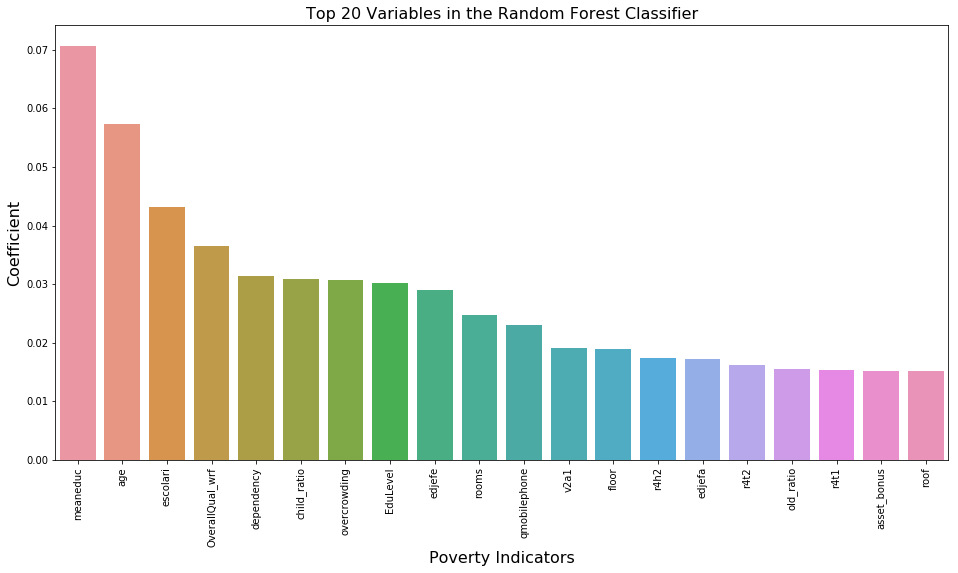

In [50]:
#Plotting the top 20 variables by their coefficient value
f, ax = plt.subplots(figsize=(16, 8))
plt.xticks(rotation='90')
sns.barplot(x=featuresRF['Variable'], y = featuresRF['Coef'])
plt.xlabel('Poverty Indicators', fontsize=16)
plt.ylabel('Coefficient', fontsize=16)
plt.title('Top 20 Variables in the Random Forest Classifier', fontsize=16)

There are several variables that I created during the Feature Engineering portion of this project that made it into the top 20. I am glad to see that.

It is very powerful to see how strong of a factor education is when it comes to living standards. I am not super enthusiastic about most government welfare programs simply because I do not think they get to the root of the problem. Providing financial aid to help certain individuals surive is essential, but what those individuals who are living in poverty really need is a good education. The focus should then be on providing equal educaitonal opportunities to people who are living in higher poverty levels. This is beyond the scope of the project, but the model does say a lot about how education relates to poverty.

Hopefully Latin American governments will not only get better at accurately classifying poverty to better allocate welfare resources, but that they will also use their data to develop long-term solutions to the underlying problems that are causing poverty in the first place. 